In [102]:
import numpy as np
import matplotlib.pyplot as plt

In [103]:
#values are taken from DESI 2024 VI: Cosmological Constraints.. 
w0_mean = 0.827
w0_sigma = 0.0632
wa_mean =  0.75
wa_sigma = 0.272
#correlation value assumed from Planck 2018
p = -0.83

#variances on the diagonal of cov matrix 
cov_00 = w0_sigma**2 
cov_11 = wa_sigma**2  
#covariances on off-diagonal of cov matrix 
cov_01 = p * w0_sigma * wa_sigma 

cov_10 = cov_01  #covariance matrix is symmetric
cov_matrix = np.array([
    [cov_00, cov_01], 
    [cov_10, cov_11]])

In [104]:
#mean vector
#the mean vector is the center of the 2D Gaussian distribution
mu = np.array([w0_mean, wa_mean])

#grid of points for the contour plot of 2D Gaussian distribution defined by the mean vector and covariance matrix
#grid covers a range around the mean, scaled by the standard deviations, set to cover 5 standard deviations in each direction
#500 values between muw0 +/- 5*sigmaw0 and muwa +/- 5*sigmawa
#99.99994% of the probability mass is within +/- 5σ
x = np.linspace(mu[0] - 5*w0_sigma, mu[0] + 5*w0_sigma, 500)
y = np.linspace(mu[1] - 5*wa_sigma, mu[1] + 5*wa_sigma, 500)
#create a meshgrid for the contour plot
#2D arrays X/Y = coordinates for the grid points (X = w0, Y = wa)
X, Y = np.meshgrid(x, y)

#calculate the 2D Gaussian distribution values for each point in the grid using the multivariate normal distribution formula
#the formula is: P(x) = (1 / (2 * pi * sqrt(det(cov)))) * exp(-0.5 * (x - mu).T @ inv(cov) @ (x - mu))
from scipy.stats import multivariate_normal
#np.dstack combines X and Y into a 2D array where each row is a point (w0, wa)
#so position[i, j] = [X[i,j], Y[i,j]]
#function from scipy.stats computes the value of the gaussian probability distribution function at each point in that array
Z = multivariate_normal.pdf(np.dstack((X, Y)), mean=mu, cov=cov_matrix) 


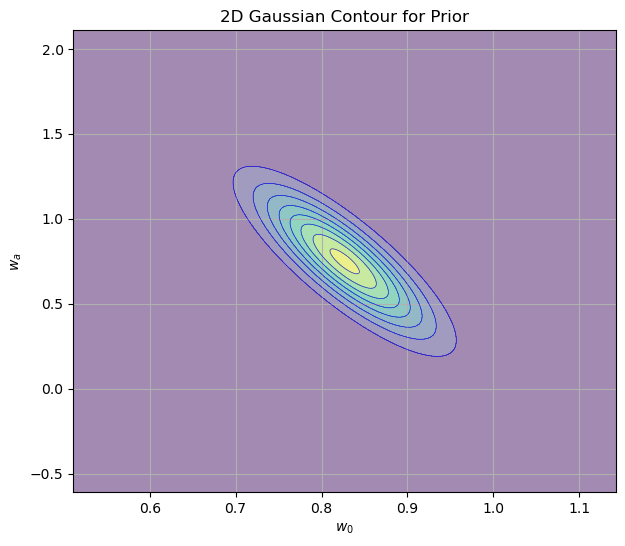

In [110]:
#plot the contour lines of the 2D Gaussian distribution
plt.figure(figsize=(7,6))
#each contour line encloses region of constant probability density
#uncertainty in each parameter = how wide the ellipse is 
#correlation between parameters = ellipse angle
#if negatively correlated = ellipses tilt downward
contour = plt.contourf(X, Y, Z, levels=10, alpha=0.5)
contourx = plt.contour(X, Y, Z, levels=10, colors='blue', linewidths=0.5, alpha=0.8)

#setting the labels and title for the plot
plt.xlabel('$w_0$')
plt.ylabel('$w_a$')
plt.title("2D Gaussian Contour for Prior")
plt.grid(True)
plt.show()

In [106]:
#importing chi2 from scipy.stats to calculate the levels for the contour plot
from scipy.stats import chi2

#ensuring that the 5*sigma ecllipse is captured in the plot by using a larger range
#the range is set to cover 8*sigma in each direction, which captures 99.9999994% of the probability mass 
x1 = np.linspace(w0_mean - 8*w0_sigma, w0_mean + 8*w0_sigma, 500)
y1 = np.linspace(wa_mean - 8*wa_sigma, wa_mean + 8*wa_sigma, 500)
#creating a new meshgrid for the larger range - defines the parameter space for plot 
X1, Y1 = np.meshgrid(x1, y1)
#2D gaussian distribution values for the new grid using the same mean vector and covariance matrix as before
Z1 = multivariate_normal.pdf(np.dstack((X1, Y1)), mean=mu, cov=cov_matrix) 

#finding the chi squared values for the confidence regions 
#converts confidence levels to chi-squared values for 2 degrees of freedom (2D = w0 and wa)
#ppf = inverse CDF (percent point function) for chi-squared distribution (what chi squared value gives x% confidence?)
#inputting confidence levels for 1σ, 2σ, 3σ, 4σ, and 5σ 
#converts to chi squared treshholds (|x-mu|^2 / sigma^2) < chi2_value = Mahalanobis Radius
chi2_values = chi2.ppf([0.683, 0.954, 0.997, 0.99994, 0.9999994], df=2) 

#convert chi sqaured region to PDF levels = height, using: level = peak * exp(-0.5 * chi2)
#works because multivariate Gaussian PDF falls off exponentially from the peak
#at distance sqrt(chi2) from the mean, the PDF value is reduced by a factor of exp(-0.5 * chi2) from peak value = f_peak 
f_peak = multivariate_normal(mean=mu, cov=cov_matrix).pdf(mu)
levels1 = f_peak * np.exp(-0.5 * chi2_values)
levels = sorted(levels1)

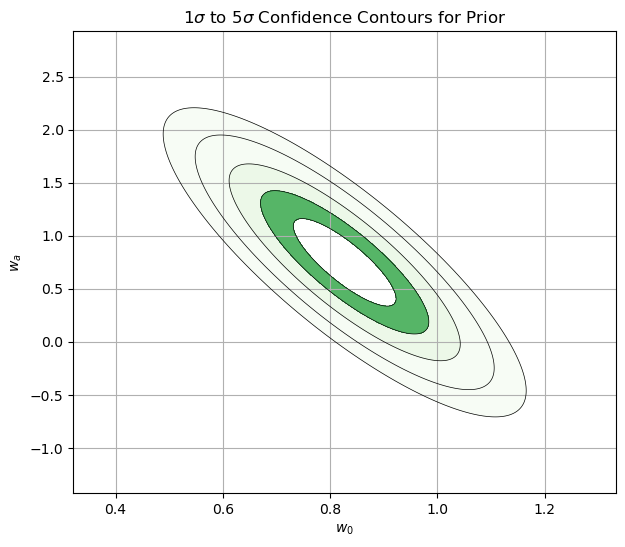

In [ ]:
#plotting the contour again with the new levels - this time for 1σ to 5σ confidence contours 
plt.figure(figsize=(7,6))
contour1 = plt.contourf(X1, Y1, Z1, levels=levels, cmap='Greens')
contour2 = plt.contour(X1, Y1, Z1, levels=levels, colors='black', linewidths=0.5)

#setting the labels and title for the plot
plt.xlabel('$w_0$')
plt.ylabel('$w_a$')
plt.title('1$\sigma$ to 5$\sigma$ Confidence Contours for Prior')
plt.grid(True)

In [ ]:
from scipy.optimize import minimize_scalar

#same formulas from lab code 
#compute the posterior width from prior and likelihood widths using the Gaussian product formula
def new_sig(sig1, sig2):
    return 1 / np.sqrt(1/sig1**2 + 1/sig2**2)

#finding the mean of the posterior 
def new_mean(sig1, sig2, alpha):
    return (alpha * sig1) / (1 + (sig2**2 / sig1**2))

#tension: how far the posterior mean is from the prior mean, measured in units of posterior std
#tension T = posterior mean / posterior std 
def posterior_tension(sig1, sig2, alpha):
    return new_mean(sig1, sig2, alpha) / new_sig(sig1, sig2)

#inverting the process: we want to find the value of sigma2 that gives us a posterior tension T close to target tension 
#cant solve algebraically, so we use numerical optimization to find the value of sigma2 that minimizes the difference
#between the posterior tension and the target tension - using scipy's minimize_scalar function
#function tries many values and finds the value of sigma2 that gives us a posterior tension close to target_t 
def find_sigma2_for_T(sig1, alpha, target_t):
    def objective(sig2):
        T = posterior_tension(sig1, sig2, alpha)
        #minimising the absolute difference between posterior tension and target tension
        return abs(T - target_t)
    #guess for sigma2 in bounds to start, adjusts until the difference is small enough (1e-5) = numerical root finding
    result = minimize_scalar(objective, bounds=(1e-5, 1.0), method='bounded')
    return result.x if result.success else None

sig1 = 0.0632
#want posterior mean to be 5 sigmas from 0
target_t = 5 

for alpha in [1, 2, 3, 4, 5]:
    required_sig2 = find_sigma2_for_T(sig1, alpha, target_t)
    print(f"For alpha = {alpha}, required sigma2 = {required_sig2:.5f}")



For alpha = 1, required sigma2 = 0.01240
For alpha = 2, required sigma2 = 0.02367
For alpha = 3, required sigma2 = 0.03350
For alpha = 4, required sigma2 = 0.04208
For alpha = 5, required sigma2 = 0.04968
